<h1> Mel-Frequency Cepstral Coefficients (MFCC)</h1>

MFCC are very commonly used as a feature for audio classification (including speech, music, and environmental sound!). This notebook shows how to compute MFCC from the spectrogram of an audio signal.

Dependencies:
* numpy: http://www.numpy.org/
* librosa: http://librosa.github.io/librosa/
* matplotlib: http://matplotlib.org/

In [1]:
# Load the libraries we need
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
from IPython.display import Audio

<h3>Step 1: Compute the spectrogram of the audio signal</h3>

In [2]:
# Load an audio file using a sampling rate of 44100 Hz. If the file is in stereo (2 channels)
# mix them down to a single channel (mono).
audiofile = 'audio/opera_10.wav'
audio, sr = librosa.load(audiofile, sr=44100, mono=True)

In [3]:
# We can listen to the audio right here in the notebook:
Audio(audio, rate=sr)

In [4]:
# Now let's compute the spectrogram of the signal. We're going to use a frame size (window size)
# of 2048 samples which corresponds to 2048/44100 = 0.046 seconds (46 ms), a hop size of 23 ms
# (1024 samples) and the Hann window function (which numpy mistakenly refers to as Hanning, 
# because there's another popular window called Hamming. Poor Julius von Hann!)
frame_size = 2048
hop_size = 1024
spectrogram = librosa.spectrum.stft(audio, n_fft=frame_size, hop_length=hop_size, window=np.hanning)

# Remember that the spectrum (and hence the spectrogram) is complex valued. To get the magnitude
# spectrum (or spectrogram we need to take the abs())
spectrogram = np.abs(spectrogram)

In [5]:
# Let's inspect the shape of the data:
# There are 1025 frequency bins (representing frequencies from 0 to sr/2 = 22050 Hz)
# There are 2296 frames, representing time from 0 to len(audio)/floar(sr) = 26.6 seconds
print(spectrogram.shape)

(1025, 1148)


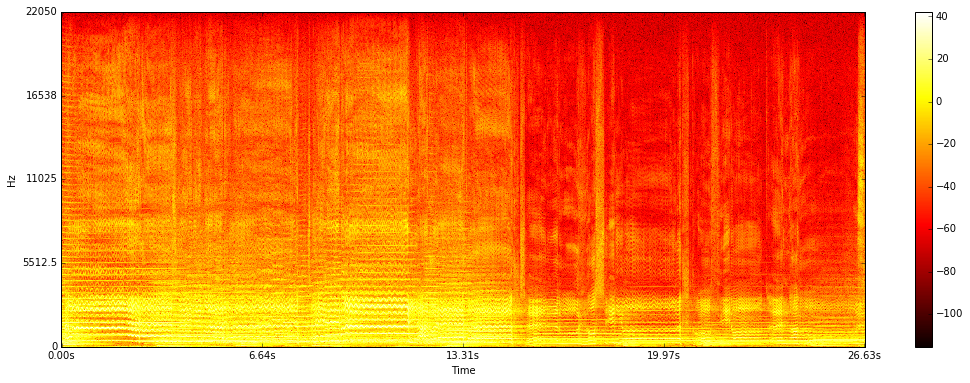

In [6]:
# Let's plot the spectrogram. We can use librosa to get all the axes right.
# Note that we take the log of the spectrogram in order to visualize it on a dB scale:
plt.figure(figsize=(18,6))
librosa.display.specshow(20*np.log10(spectrogram), sr=sr, hop_length=hop_size,  
                         x_axis='time', y_axis='linear', cmap='hot')
plt.colorbar()
plt.show()

<h3>Step 2: apply the mel-filterbank to obtain a mel-spectrogram</h3>

Lets define conversion functions from a Hz scale to the Mel scale:

In [7]:
def hz2mel(x):
    return 1127.01028 * np.log(1 + x/700.)

def mel2hz(x):
    return 700 * (np.exp(x/1127.01028) - 1)

Next, we define the parameters for computing the MFCC. In order case, this includes:
1. The number of mel bands to use for the filterbank
2. The size of the real ftt (frame_size / 2 + 1)

In [8]:
# Mel parameters
n_bands = 40
n_specbins = 1025

# Let's compute the minimum and maximum frequencies on the Mel scale:
mel_min = hz2mel(0)
mel_max = hz2mel(sr/2.)
print(mel_min, mel_max)

(0.0, 3923.3933678294429)


Next we need to generate the Mel filterbank. To do this we define equally-spaced points on the mel scale. Each group of 3 consecutive points will represent that start, peak, and end of one mel-filter:

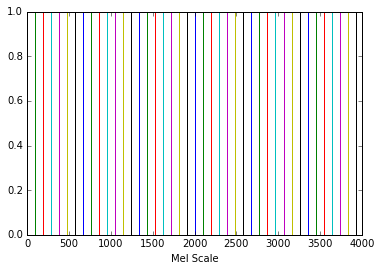

In [9]:
n_points = n_bands + 2
mel_points = np.linspace(mel_min, mel_max, num=n_points)
for point in mel_points:
    plt.plot([point, point], [0, 1])
plt.xlabel('Mel Scale')
plt.show()

Now we convert the points back to Hertz. Note that the points are now logarithmically spaced!

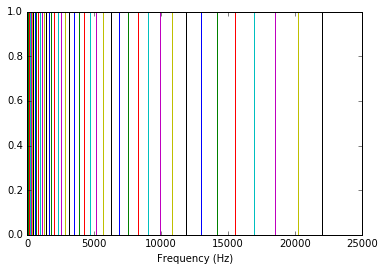

In [10]:
hz_points = mel2hz(mel_points)
for point in hz_points:
    plt.plot([point, point], [0, 1])
plt.xlabel('Frequency (Hz)')
plt.show()

Next, we calculate the equivalent position of these points in fft bin numbers:

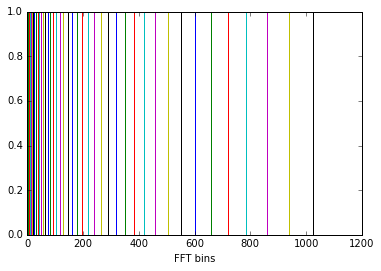

In [11]:
fft_points = np.floor((frame_size + 1) * hz_points / float(sr))
fft_points = np.array([int(x) for x in fft_points])
for point in fft_points:
    plt.plot([point, point], [0, 1])
plt.xlabel('FFT bins')
plt.show()

Now we use the points to construct a filterbank of triangular filters (other filter shapes can be used).
We'll store each filter in a row of the filterbank matrix:

In [12]:
# Each iteration of the loop creates one filter
filterbank = np.zeros((n_bands, n_specbins))
for m in range(1,n_bands+1):
    filterbank[m-1, :fft_points[m-1]] = 0
    filterbank[m-1, fft_points[m-1]:fft_points[m]+1] = (
        (np.arange(fft_points[m-1],fft_points[m]+1) - fft_points[m-1]) / float(fft_points[m] - fft_points[m-1]))
    filterbank[m-1, fft_points[m]:fft_points[m+1]+1] = (
        (fft_points[m+1] - np.arange(fft_points[m],fft_points[m+1]+1)) / float(fft_points[m+1]-fft_points[m]))
    filterbank[m-1, fft_points[m+1]+1:] = 0

In [13]:
# The filterbank will have as many filters as n_bands (which we can choose!)
# Each filter is the same size as the real fft:
print(filterbank.shape)

(40, 1025)


Let's visualize the filterbank matrix:

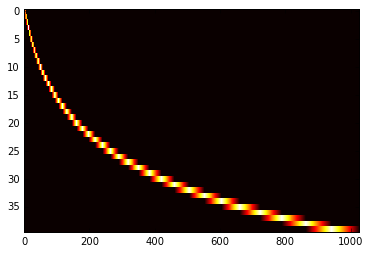

In [14]:
plt.figure()
plt.imshow(filterbank, interpolation='nearest', aspect='auto', cmap='hot')
plt.grid(b=False)
plt.show()

In the lecture slides the filterbank matrix is mirrored:

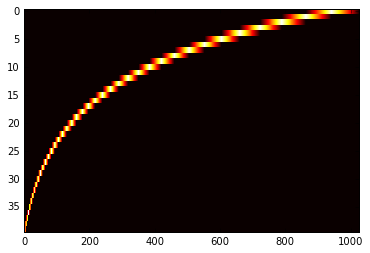

In [15]:
plt.figure()
plt.imshow(np.flipud(filterbank), interpolation='nearest', aspect='auto', cmap='hot')
plt.grid(b=False)
plt.show()

It's helpful to visualize all the filters on the same freqeuncy axis:

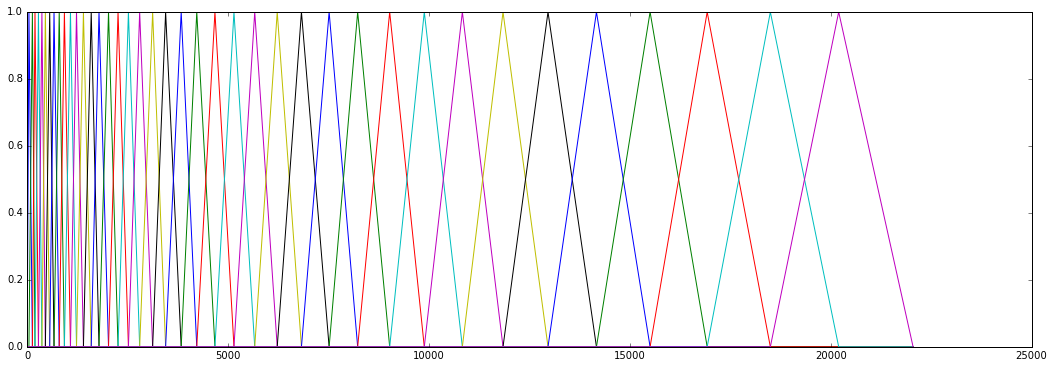

In [16]:
plt.figure(figsize=(18,6))
for f in filterbank:
    plt.plot(np.arange(len(f)) * sr / float(frame_size), f)
plt.show()

Right now all the filters have the same heigh (of 1): we need every filter to sum to 1 (so that applying
the filterbank weights all bands equally), so let's normalize the filterbank:

In [17]:
# Normalize the filterbank
filterbank /= filterbank.sum(axis=1).reshape(-1, 1)

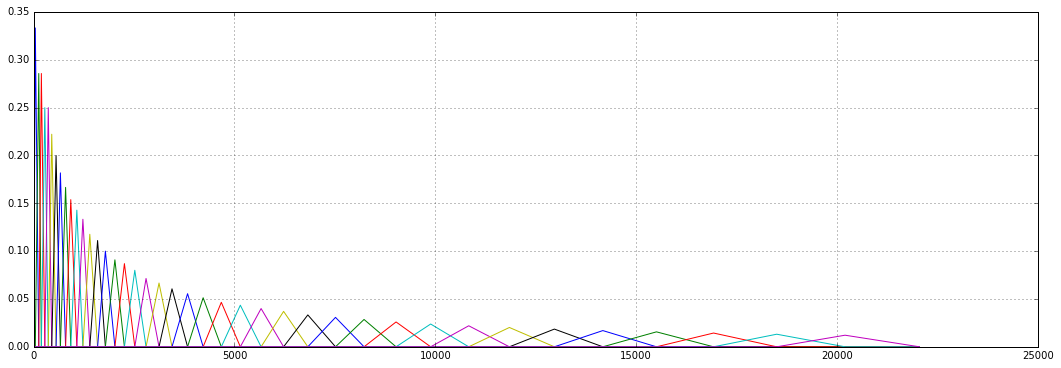

In [18]:
plt.figure(figsize=(18,6))
for f in filterbank:
    plt.plot(np.arange(len(f)) * sr / float(frame_size), f)
plt.grid()
plt.show()

In [19]:
# We obtain the Mel-spectrogram by applying the filterbank to the spectrogram.
# Let's examine the dimensions of the matrices:
print(filterbank.shape, spectrogram.shape)

((40, 1025), (1025, 1148))


Now that we have the mel filterbank, we can compute the mel-spectrogram:

In [20]:
# Compute the mel-spectrogram
melspec = np.dot(filterbank, spectrogram)
print(melspec.shape)

(40, 1148)


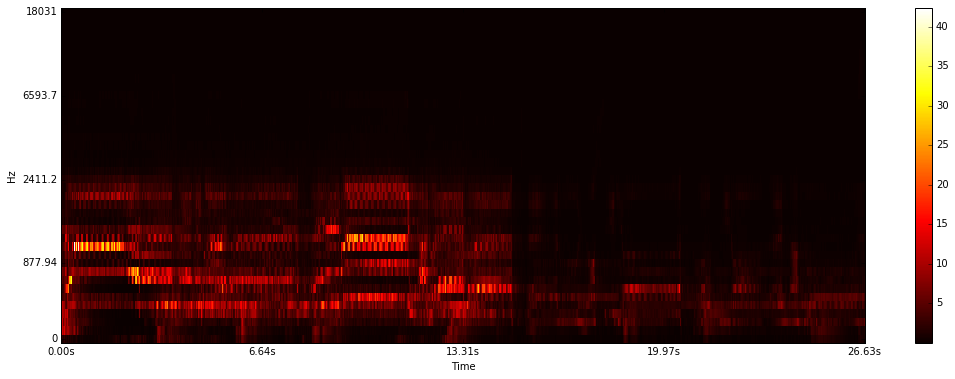

In [21]:
# Let's plot the Mel-spectrogram. We can use librosa to get all the axes right.
# Note that we take the amplitudes are still on a linear scale:
plt.figure(figsize=(18,6))
librosa.display.specshow(melspec, sr=sr, hop_length=hop_size,  
                         x_axis='time', y_axis='mel', fmax=sr/2, cmap='hot')
plt.colorbar()
plt.show()

<h3>Step 3: convert the magnitudes to a dB (logarithmic) scale</h3>

The next step is to take the logarithm so that the magnitudes are on a dB scale:

In [22]:
melspec = 20*np.log10(melspec)

Let's visualize the (log)mel-spectrogram:

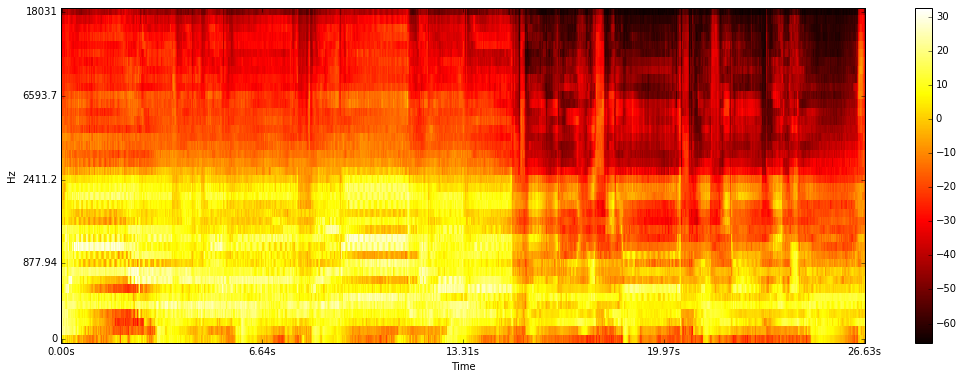

In [23]:
# Let's plot the (log)Mel-spectrogram. We can use librosa to get all the axes right.
plt.figure(figsize=(18,6))
librosa.display.specshow(melspec, sr=sr, hop_length=hop_size,  
                         x_axis='time', y_axis='mel', fmax=sr/2, cmap='hot')
plt.colorbar()
plt.show()

<h3>Step 4: apply the Discrete Cosine Transform</h3>

Next, we need to choose the parameters for the Discrete Cosine Trasnform (DCT) and build the DCT matrix. Note that we can choose the number of DCT components to compute, the other dimension of the matrix must match the the first dimension of the mel-spectrogram, i.e. the number of mel bands n_bands:

In [24]:
# Number of DCT components: we can choose this!
n_dct = 15

# Build the DCT matrix:
DCT = np.zeros((n_dct, n_bands))
for i in range(n_dct):
    DCT[i] = np.sqrt(2/float(n_bands)) * np.cos(np.pi*i/float(n_bands)*(np.arange(n_bands)-0.5))

Let's visualize the DCT matrix:

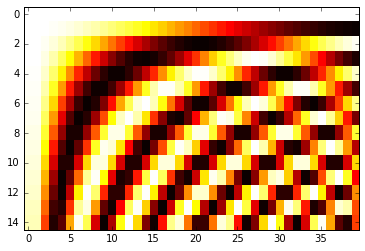

In [25]:
plt.figure()
plt.imshow(DCT, interpolation='nearest', aspect='auto', cmap='hot')
plt.grid(b=False)
plt.show()

In the lecture slides the DCT matrix is mirrored:

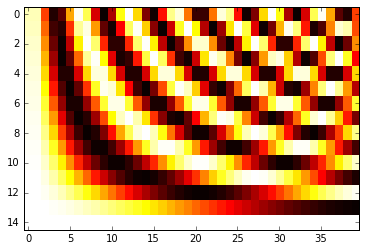

In [26]:
plt.figure()
plt.imshow(np.flipud(DCT), interpolation='nearest', aspect='auto', cmap='hot')
plt.grid(b=False)
plt.show()

In [27]:
# Let's examine the shapes of the mel-spectrogram and the DCT matrix:
print(DCT.shape, melspec.shape)

((15, 40), (40, 1148))


Now we can compute the MFCC by applying the DCT to the mel-spectrogram:

In [28]:
# Compute MFCC by applying DCT to mel-specrtogram:
mfcc = np.dot(DCT, melspec)
print(mfcc.shape)

(15, 1148)


Finally, lets visualize the resulting MFCC:

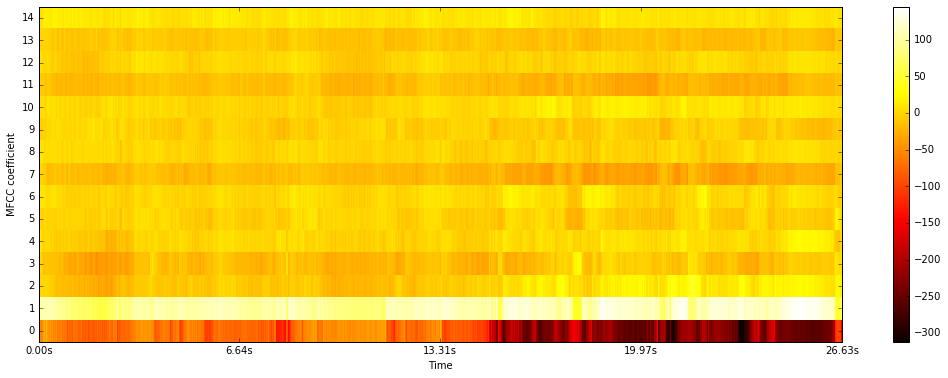

In [29]:
plt.figure(figsize=(18,6))
librosa.display.specshow(mfcc, sr=sr, hop_length=hop_size,  
                         x_axis='time', cmap='hot')
plt.ylabel('MFCC coefficient')
plt.yticks(range(len(mfcc)))
plt.colorbar()
plt.show()

<h3>Some notes about using MFCC for audio classification</h3>

**Discaring the first coefficient**

When using MFCC for classification, it is customary to discard the first coefficieint (0), since it corresponds to the DC component of the signal (i.e. the signals amplitude or roughly speaking "loudness"), which is not something we want the classifier to pick up on (i.e. we want it to classify sounds independently of their loudness).

**Discarding the upper coefficients**

The more coefficients we keep, the higer the dimensionality of our representation and the more accurately it describes the spectral envelope of the sounds being analyzed. For classification we want a representation that captures the general shape of the envelope (which we know is related to the timbre of the sound) but we don't want a representation that is so detailed that it captures traists of the envelope that rae specific to one sound but not to the class of sounds we want to classify. Consequently, it's common to discard the higher MFCC coefficients and keep something between 13 and 25 (this of course depends on how many mel-bands and DCT coefficients we compute in the first place).

**A baseline setup for audio classification**

As an example, a common setup for audio classification with MFCC is to compute between 40-128 mel bands, the same number of DCT coefficients, and then keep the bottom 13-25 MFCC coefficients for further processing (oftentimes discarding the lowest coefficient).